In [1]:
import pandas as pd
import numpy as np
import csv
import os
import random
import torch
import torch
torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
import sklearn.model_selection as model_selection
from transformers import BertForSequenceClassification, BertTokenizerFast
import time
import copy
from tqdm.notebook import tqdm

In [2]:
def set_seed(seed=42):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [3]:
df=pd.read_csv("../input/amazon-ml-challenge-2021-hackerearth/train.csv", escapechar = "\\", quoting = csv.QUOTE_NONE)

In [4]:
num_labels=df["BROWSE_NODE_ID"].nunique()

In [5]:
id2lbl={lbl: idx for idx,lbl in enumerate(list(df["BROWSE_NODE_ID"].unique()))}
lbl2id={lbl:idx for idx,lbl in id2lbl.items()}

In [6]:
set_seed()

In [7]:
df["BROWSE_NODE_ID"]=df["BROWSE_NODE_ID"].map(id2lbl)

In [8]:
def create_folds(data, num_splits):
    data["kfold"] = -1
    data = data.sample(frac=1).reset_index(drop=True)
    y=df["BROWSE_NODE_ID"]
    kf = model_selection.StratifiedKFold(n_splits=num_splits)
    for f, (t_, v_) in enumerate(kf.split(X=data, y=y)):
        data.loc[v_, 'kfold'] = f
    return data

In [9]:
df=create_folds(df, 5)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [10]:
df=df.loc[df.kfold.isin([0,2])]
df=df.reset_index(drop=True)
df.head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID,kfold
0,"Amsik®Blind Spot Round Mirror Black, (Real Gla...",The mirrors easily mount to the vehicle's left...,"[It is small, but it is smart mirror, and work...",AMSIK,3873,0
1,Nivea Face Sun Block Whitening Cream SPF 50 Pa...,Nivea Sun Fac Sun Block Whitening Cream Spf 50...,NIVEA face SUN Block Whitening Cream SPF 50 PA ++,Nivea,33,0
2,Narayan Creation Pashmina Palazzo Suit Dupatta...,Narayan creatins pashmina unstitched palazzo s...,NaN,Generic,328,0
3,Q-rious Women's Silicon Strap Spagettis/Camiso...,Trendy Q-rious Spagetti with sequin detachable...,"[Silicon and Elastic strap option,Detachable S...",Q-rious,1048,0
4,Hanes Men's Pullover EcoSmart Fleece Hooded Sw...,NaN,"[Made with a portion of recycled polyester,Pat...",Hanes,1409,0


In [11]:
df.loc[df['BROWSE_NODE_ID']==1045].head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID,kfold
99942,Adam Audio A77X Powered Studio Monitor Right,A77X Powered Studio Monitor Right. In some set...,[Solid response down to 38Hz Award-winning X-A...,Adam Audio,1045,0
115635,Mackie CR4 Creative Reference Multimedia Monit...,Mackie CR4 Creative Reference Multimedia Monit...,NaN,Mackie,1045,0
191786,Peavey PV23XO Stereo 2 Way/Mono 3 Way Crossover,Peavey 2 WAY STEREO 3 WAY MONO CROSSOVER,Peavey 2 WAY STEREO 3 WAY MONO CROSSOVER,Peavey,1045,0
226404,"KRK V4 Series 4 4"" 2-Way Powered Studio Refere...",NaN,[The V4S4 has the KRK custom designed Kevlar t...,KRK,1045,0
226531,"Mackie CR3 CR Series 3"" Creative Reference Mul...",CR3 - 3&quot; Creative Reference Multimedia Mo...,"[Mackie CR Series 3"" Creative Reference Multim...",Mackie,1045,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161210 entries, 0 to 1161209
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   TITLE           1161190 non-null  object
 1   DESCRIPTION     871977 non-null   object
 2   BULLET_POINTS   1094560 non-null  object
 3   BRAND           1138381 non-null  object
 4   BROWSE_NODE_ID  1161210 non-null  int64 
 5   kfold           1161210 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 53.2+ MB


In [13]:
df.isnull().sum()

TITLE                 20
DESCRIPTION       289233
BULLET_POINTS      66650
BRAND              22829
BROWSE_NODE_ID         0
kfold                  0
dtype: int64

In [14]:
temp=df.dropna(subset=['TITLE'])
temp=temp.reset_index(drop=True)

In [15]:
temp.isnull().sum()

TITLE                  0
DESCRIPTION       289231
BULLET_POINTS      66648
BRAND              22826
BROWSE_NODE_ID         0
kfold                  0
dtype: int64

In [16]:
total_words=0
for title in temp['TITLE']:
    total_words+=len(title.split())

In [17]:
total_words/len(temp)

13.5439437129152

In [18]:
temp=df.dropna(subset=['DESCRIPTION'])
total_words=0
for title in temp['DESCRIPTION']:
    total_words+=len(title.split())
total_words/len(temp)

90.47320628869798

In [19]:
temp=df.dropna(subset=['TITLE'])
temp=temp.fillna(" ")

In [20]:
temp.head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID,kfold
0,"Amsik®Blind Spot Round Mirror Black, (Real Gla...",The mirrors easily mount to the vehicle's left...,"[It is small, but it is smart mirror, and work...",AMSIK,3873,0
1,Nivea Face Sun Block Whitening Cream SPF 50 Pa...,Nivea Sun Fac Sun Block Whitening Cream Spf 50...,NIVEA face SUN Block Whitening Cream SPF 50 PA ++,Nivea,33,0
2,Narayan Creation Pashmina Palazzo Suit Dupatta...,Narayan creatins pashmina unstitched palazzo s...,,Generic,328,0
3,Q-rious Women's Silicon Strap Spagettis/Camiso...,Trendy Q-rious Spagetti with sequin detachable...,"[Silicon and Elastic strap option,Detachable S...",Q-rious,1048,0
4,Hanes Men's Pullover EcoSmart Fleece Hooded Sw...,,"[Made with a portion of recycled polyester,Pat...",Hanes,1409,0


In [21]:
" ".join(temp["BULLET_POINTS"][0].split(","))[:-1][1:]

'It is small  but it is smart mirror  and works together with the side mirror so great The blind spots mirrors can be 360° rotatable + 30° sway adjustable with the angle regulator type . Upgraded real glass mirror body  equips with strong 3M adhesive tape for fast installation. 2 Pcs/set with double tape packaged in all English instruction.'

In [22]:
wholeSentence=[]
for idx,row in temp.iterrows(): 
    if(idx%100000==0):
        print(f"{idx} Done")
    wholeSentence.append(row[0]+row[1]+" ".join(row[2].split(","))[:-1][1:])

0 Done
100000 Done
200000 Done
300000 Done
400000 Done
500000 Done
600000 Done
700000 Done
800000 Done
900000 Done
1000000 Done
1100000 Done


In [23]:
temp["WHOLE SENTENCE"]=wholeSentence

In [24]:
temp=temp.reset_index(drop=True)

In [25]:
temp.head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID,kfold,WHOLE SENTENCE
0,"Amsik®Blind Spot Round Mirror Black, (Real Gla...",The mirrors easily mount to the vehicle's left...,"[It is small, but it is smart mirror, and work...",AMSIK,3873,0,"Amsik®Blind Spot Round Mirror Black, (Real Gla..."
1,Nivea Face Sun Block Whitening Cream SPF 50 Pa...,Nivea Sun Fac Sun Block Whitening Cream Spf 50...,NIVEA face SUN Block Whitening Cream SPF 50 PA ++,Nivea,33,0,Nivea Face Sun Block Whitening Cream SPF 50 Pa...
2,Narayan Creation Pashmina Palazzo Suit Dupatta...,Narayan creatins pashmina unstitched palazzo s...,,Generic,328,0,Narayan Creation Pashmina Palazzo Suit Dupatta...
3,Q-rious Women's Silicon Strap Spagettis/Camiso...,Trendy Q-rious Spagetti with sequin detachable...,"[Silicon and Elastic strap option,Detachable S...",Q-rious,1048,0,Q-rious Women's Silicon Strap Spagettis/Camiso...
4,Hanes Men's Pullover EcoSmart Fleece Hooded Sw...,,"[Made with a portion of recycled polyester,Pat...",Hanes,1409,0,Hanes Men's Pullover EcoSmart Fleece Hooded Sw...


# BERT

In [26]:
dev=torch.device('cuda')

In [27]:
temp["BROWSE_NODE_ID"].value_counts()

677     86425
5       28169
773     20744
679     18236
4       13727
        ...  
7930        1
9550        1
9544        1
9361        1
5306        1
Name: BROWSE_NODE_ID, Length: 9375, dtype: int64

In [28]:
train_text, val_text, train_labels, val_labels = train_test_split(temp['WHOLE SENTENCE'], temp['BROWSE_NODE_ID'],
                                                                    test_size=0.05)

In [29]:
train_text=train_text.reset_index(drop=True)
train_labels=train_labels.reset_index(drop=True)
val_text=val_text.reset_index(drop=True)
val_labels=val_labels.reset_index(drop=True)

In [30]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

<AxesSubplot:>

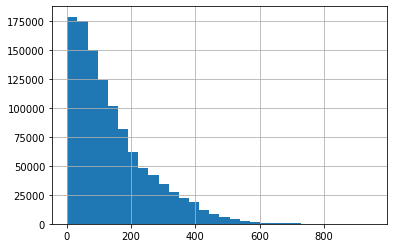

In [31]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [32]:
max_seq_len = 64

In [33]:
class amazonDataset(Dataset):
  def __init__(self,text,label,tokenizer):
    self.sentence=text
    self.label=label
    self.tokenizer=tokenizer

  def __len__(self):
    return len(self.sentence)
  
  def __getitem__(self,idx):
    inp_tokens=self.tokenizer.encode_plus(self.sentence[idx], 
                                          padding="max_length", 
                                          add_special_tokens=True,
                                          max_length=max_seq_len, 
                                          truncation=True)
    inp_id=inp_tokens.input_ids
    inp_mask=inp_tokens.attention_mask
    inp_type_ids=inp_tokens.token_type_ids
    labels=self.label[idx]

    return {
#         "text":self.sentence,
        "input_ids":torch.tensor(inp_id, dtype=torch.long),
        "input_attention_mask":torch.tensor(inp_mask, dtype=torch.long),
        "input_type_ids":torch.tensor(inp_type_ids, dtype=torch.long),
        "labels":torch.tensor(labels, dtype=torch.float)
    }

In [34]:
train_dataset = amazonDataset(train_text, train_labels, tokenizer)
val_dataset = amazonDataset(val_text, val_labels, tokenizer)

In [35]:
train_dataloader=DataLoader(train_dataset,
                            batch_size=128,
                            shuffle=True,
                            num_workers=2,
                           pin_memory=True)
val_dataloader=DataLoader(val_dataset,
                            batch_size=128,
                            shuffle=False,
                            num_workers=2,
                           pin_memory=True)

In [36]:
dataloaders={'train':train_dataloader, 'eval':val_dataloader }
dataset_sizes={'train':len(train_dataset), 'eval':len(val_dataset)}

In [37]:
# class BERTBaseUncased(nn.Module):
#     def __init__(self):
#         super(BERTBaseUncased, self).__init__()
#         self.bert=AutoModel.from_pretrained('bert-base-uncased')
#         self.dropout = nn.Dropout(0.1)
#         self.relu =  nn.ReLU()
#         self.fc1 = nn.Linear(768,9919)
        
#     def forward(self,ids,mask,token_type_ids):
#         a, o2 = self.bert(
#             ids,
#             attention_mask=mask,
#             token_type_ids=token_type_ids)
#         bo=self.dropout(o2)
#         output=self.fc1(bo)
#         return output

In [38]:
model=BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                    num_labels=9919)
print(model)
model=torch.load("../input/amazon-ml-models/BERTBaseBaselineNoset.pth")
model.to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [39]:
def train_fn(model,loss_fn,optimizer,scheduler,num_epochs=1):
    since=time.time()
    best_wts=copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    for epoch in range(num_epochs):
        print(f'Epoch:{epoch}/{num_epochs}')
        print('-'*10)
        
        for mode in ['train','eval']:
            if mode=='train':
                model.train()
            elif mode=='eval':
                model.eval()
            
            running_loss=0.0
            running_corrects=0.0
            
            for data in tqdm(dataloaders[mode]):
                input_ids = data["input_ids"].to(dev, dtype=torch.long)
                labels = data['labels'].to(dev, dtype=torch.long)
                mask = data["input_attention_mask"].to(dev, dtype=torch.long)
                token_type_ids = data['input_type_ids'].to(dev, dtype=torch.long)
            
                optimizer.zero_grad()
                with torch.set_grad_enabled(mode=='train'):
                    outputs=model(
                                input_ids =input_ids,
                                attention_mask=mask,
                                token_type_ids=token_type_ids,
                                labels=labels
                            )
                    loss, logits=outputs.loss, outputs.logits
                    _,preds=torch.max(logits,1)
                    
                    if mode=='train':
                        loss.backward()
                        optimizer.step()                    
                    running_loss += loss.item()                    
                    running_corrects += torch.sum(preds == labels.data)

            if mode == 'train':
                scheduler.step()
                
            epoch_loss=running_loss/dataset_sizes[mode]
            epoch_accuracy=running_corrects.double()/dataset_sizes[mode]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                mode, epoch_loss, epoch_accuracy))
            
            if mode=='eval' and epoch_loss<best_loss:
                best_wts=copy.deepcopy(model.state_dict())
                best_acc=epoch_accuracy
                best_loss=epoch_loss
            
            print()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val loss: {:4f}'.format(best_loss))
        print('Best val Acc: {:4f}'.format(best_acc))
    
        model.load_state_dict(best_wts)
    return model

In [40]:
model = train_fn(model, 
               criterion, 
               optimizer, 
               exp_lr_scheduler,
               num_epochs=5)

Epoch:0/5
----------


  0%|          | 0/8619 [00:00<?, ?it/s]

train Loss: 0.0134 Acc: 0.6963



  0%|          | 0/454 [00:00<?, ?it/s]

eval Loss: 0.0131 Acc: 0.7020

Training complete in 103m 39s
Best val loss: 0.013128
Best val Acc: 0.702032
Epoch:1/5
----------


  0%|          | 0/8619 [00:00<?, ?it/s]

train Loss: 0.0133 Acc: 0.6997



  0%|          | 0/454 [00:00<?, ?it/s]

eval Loss: 0.0130 Acc: 0.7040

Training complete in 207m 29s
Best val loss: 0.013026
Best val Acc: 0.703961
Epoch:2/5
----------


  0%|          | 0/8619 [00:00<?, ?it/s]

train Loss: 0.0131 Acc: 0.7019



  0%|          | 0/454 [00:00<?, ?it/s]

eval Loss: 0.0129 Acc: 0.7049

Training complete in 311m 16s
Best val loss: 0.012929
Best val Acc: 0.704909
Epoch:3/5
----------


  0%|          | 0/8619 [00:00<?, ?it/s]

train Loss: 0.0130 Acc: 0.7037



  0%|          | 0/454 [00:00<?, ?it/s]

eval Loss: 0.0128 Acc: 0.7067

Training complete in 415m 9s
Best val loss: 0.012842
Best val Acc: 0.706666
Epoch:4/5
----------


  0%|          | 0/8619 [00:00<?, ?it/s]

train Loss: 0.0129 Acc: 0.7057



  0%|          | 0/454 [00:00<?, ?it/s]

eval Loss: 0.0128 Acc: 0.7080

Training complete in 519m 8s
Best val loss: 0.012753
Best val Acc: 0.708009


In [41]:
torch.save(model,"BERTBaseBaselineNoset.pth")